In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

"""
[train.csv]                                         [test.csv]
ID : 샘플별 고유 ID                                 ID : 샘플별 고유 ID
gender : 성별                                       gender : 성별
age : 연령                                          age : 연령
height : 키(cm)                                     height : 키(cm)
weight : 몸무게(kg)                                 weight : 몸무게(kg)
cholesterol : 콜레스테롤 수치                       cholesterol : 콜레스테롤 수치
systolic_blood_pressure : 수축기 혈압               systolic_blood_pressure : 수축기 혈압
diastolic_blood_pressure : 이완기 혈압              diastolic_blood_pressure : 이완기 혈압
glucose : 혈당 수치(mg/dL)                          glucose : 혈당 수치(mg/dL)
bone_density : 골밀도(g/cm²)                        bone_density : 골밀도(g/cm²)
activity : 생활시 운동 강도                         activity : 생활시 운동 강도
smoke_status : 흡연 상태                            smoke_status : 흡연 상태
medical_history : 만성질환                          medical_history : 만성질환
family_medical_history : 가족력                     family_medical_history : 가족력
sleep_pattern : 수면패턴                            sleep_pattern : 수면패턴
edu_level : 학력                                    edu_level : 학력
mean_working : 1주일당 평균 근로 시간               mean_working : 1주일당 평균 근로 시간
stress_score : (TARGET) 스트레스 점수                    
"""

display(train.shape)

(3000, 18)

In [3]:
# BMI => 몸무게[kg] / 키[cm]^2
# 혈압차(맥압) => 수축성 혈압 - 이완성 혈압
def add_features(df):
    df['BMI'] = df['weight'] / ((df['height']/100)**2)
    df['bp_diff'] = df['systolic_blood_pressure'] - df['diastolic_blood_pressure']
    return df

train = add_features(train)
test = add_features(test)

,ID,gender,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,smoke_status,medical_history,family_medical_history,sleep_pattern,edu_level,mean_working,stress_score,BMI,bp_diff
0,TRAIN_0000,F,72,161.49,58.47,279.84,165,100,143.35,0.87,moderate,ex-smoker,high blood pressure,diabetes,sleep difficulty,bachelors degree,NaN,0.63,22.420321,65
1,TRAIN_0001,M,88,179.87,77.60,257.37,178,111,146.94,0.07,moderate,ex-smoker,NaN,diabetes,normal,graduate degree,NaN,0.83,23.985250,67
2,TRAIN_0002,M,47,182.47,89.93,226.66,134,95,142.61,1.18,light,ex-smoker,NaN,NaN,normal,high school diploma,9.0,0.70,27.009817,39
3,TRAIN_0003,M,69,185.78,68.63,206.74,158,92,137.26,0.48,intense,ex-smoker,high blood pressure,NaN,oversleeping,graduate degree,NaN,0.17,19.884564,66
4,TRAIN_0004,F,81,164.63,71.53,255.92,171,116,129.37,0.34,moderate,ex-smoker,diabetes,diabetes,sleep difficulty,bachelors degree,NaN,0.36,26.391876,55


,dtype,%missing,n_unique
family_medical_history,object,49.53,3
medical_history,object,42.97,3
mean_working,float64,34.40,13
edu_level,object,20.23,3
height,float64,0.00,1828
age,int64,0.00,73
gender,object,0.00,2
ID,object,0.00,3000
weight,float64,0.00,1986
cholesterol,float64,0.00,2215


,count,mean,std,min,25%,50%,75%,max
age,3000.0,53.068000,20.672070,17.000000,35.000000,53.000000,72.000000,89.000000
height,3000.0,168.585687,9.351876,141.130000,161.800000,168.115000,175.352500,195.280000
weight,3000.0,72.486680,13.167222,36.320000,63.035000,71.240000,81.832500,120.880000
cholesterol,3000.0,233.910523,24.333434,148.810000,216.927500,234.255000,250.377500,313.350000
systolic_blood_pressure,3000.0,146.144333,15.845310,97.000000,135.000000,146.000000,158.000000,191.000000
diastolic_blood_pressure,3000.0,95.504000,9.895283,60.000000,89.000000,95.000000,102.000000,124.000000
glucose,3000.0,126.467720,18.536844,70.050000,113.912500,126.555000,139.180000,185.740000
bone_density,3000.0,0.933367,0.444783,-0.220000,0.560000,0.940000,1.300000,2.000000
mean_working,1968.0,8.716972,1.628944,4.000000,8.000000,9.000000,10.000000,16.000000
stress_score,3000.0,0.482130,0.288252,0.000000,0.230000,0.480000,0.730000,1.000000



▶ gender


gender
F    1508
M    1492
Name: count, dtype: int64


▶ activity


activity
moderate    1431
light        894
intense      675
Name: count, dtype: int64


▶ smoke_status


smoke_status
ex-smoker         1177
non-smoker        1039
current-smoker     784
Name: count, dtype: int64


▶ medical_history


medical_history
high blood pressure    697
heart disease          508
diabetes               506
Name: count, dtype: int64


▶ family_medical_history


family_medical_history
diabetes               615
high blood pressure    480
heart disease          419
Name: count, dtype: int64


▶ sleep_pattern


sleep_pattern
normal              1557
sleep difficulty    1019
oversleeping         424
Name: count, dtype: int64


▶ edu_level


edu_level
high school diploma    924
bachelors degree       880
graduate degree        589
Name: count, dtype: int64

c:\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\허민엽\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


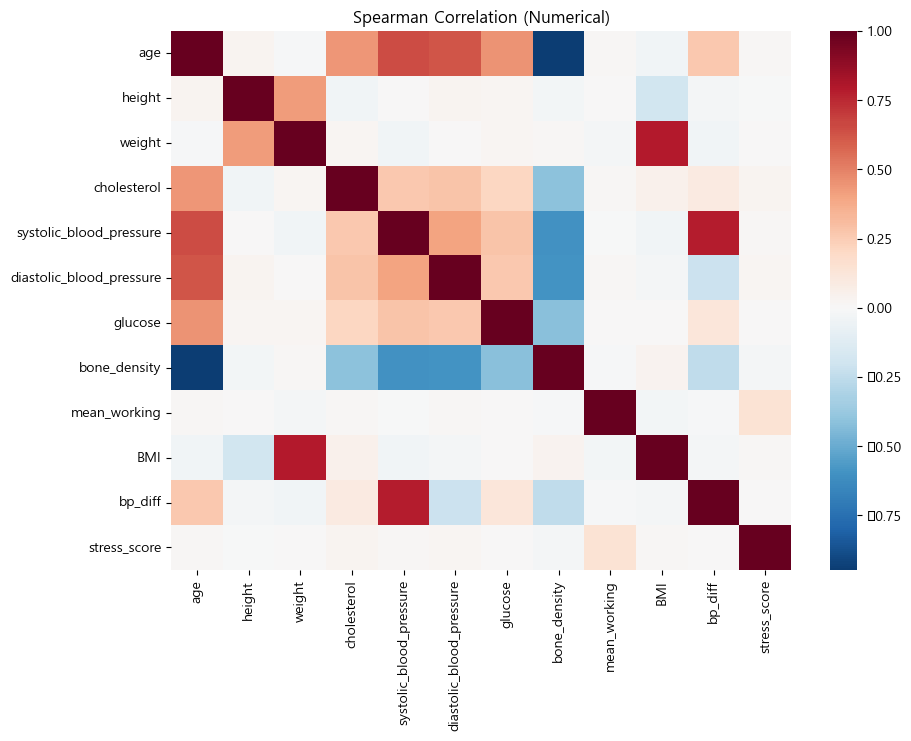

stress_score                1.000000
mean_working                0.145073
cholesterol                 0.026804
diastolic_blood_pressure    0.019255
age                         0.019001
systolic_blood_pressure     0.017789
BMI                         0.016798
weight                      0.007825
bp_diff                     0.006089
glucose                    -0.003056
height                     -0.010767
bone_density               -0.022841
Name: stress_score, dtype: float64

In [4]:
display(train.head(5))

def missing_ratio(df):
    return (df.isna().mean()*100).round(2).rename("%missing")

info = pd.DataFrame({
    "dtype"     : train.dtypes,
    "%missing"  : missing_ratio(train),
    "n_unique"  : train.nunique()
})
display(info.sort_values("%missing", ascending=False))

# 수치형 기본 통계
display(train.describe().T)

# 범주형 빈도 상위 5개씩
cat_cols = train.select_dtypes("object").columns.drop(["ID"])
for col in cat_cols:
    print(f"\n▶ {col}")
    display(train[col].value_counts().head())

num_cols = train.select_dtypes(include=[np.number]).columns.drop("stress_score")

corr = train[num_cols.tolist() + ["stress_score"]].corr(method="spearman")
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=False, cmap="RdBu_r", center=0)
plt.title("Spearman Correlation (Numerical)")
plt.show()

corr["stress_score"].sort_values(ascending=False)

In [5]:
train.isnull().sum()

ID                             0
gender                         0
age                            0
height                         0
weight                         0
cholesterol                    0
systolic_blood_pressure        0
diastolic_blood_pressure       0
glucose                        0
bone_density                   0
activity                       0
smoke_status                   0
medical_history             1289
family_medical_history      1486
sleep_pattern                  0
edu_level                    607
mean_working                1032
stress_score                   0
BMI                            0
bp_diff                        0
dtype: int64

In [6]:
# 결측값 있는 칼럼(column) 확인
missing_columns_train = train.columns[train.isnull().sum() > 0]
missing_columns_train

Index(['medical_history', 'family_medical_history', 'edu_level',
       'mean_working'],
      dtype='object')

In [7]:
train[missing_columns_train].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   medical_history         1711 non-null   object 
 1   family_medical_history  1514 non-null   object 
 2   edu_level               2393 non-null   object 
 3   mean_working            1968 non-null   float64
dtypes: float64(1), object(3)
memory usage: 93.9+ KB


In [8]:
categorical_na_cols = []
numerical_na_cols = []

# 결측값이 있는 각 칼럼에 대해 데이터 타입 확인
for col in missing_columns_train:
    # 해당 칼럼이 범주형(object 또는 category)인지 확인
    if col in train.select_dtypes(include=['object', 'category']).columns:
        categorical_na_cols.append(col)
    # 해당 칼럼이 수치형(int 또는 float)인지 확인
    elif col in train.select_dtypes(include=['int', 'float']).columns:
        numerical_na_cols.append(col)

print("결측값이 있는 범주형 변수:", categorical_na_cols)
print("결측값이 있는 수치형 변수:", numerical_na_cols)

결측값이 있는 범주형 변수: ['medical_history', 'family_medical_history', 'edu_level']
결측값이 있는 수치형 변수: ['mean_working']


In [9]:
# 범주형 변수의 결측값을 최빈값으로 대체
# 최빈값 -> 가장 많이 관측된 값
for col in categorical_na_cols:
    # # 학습 데이터에서 최빈값 계산
    # most_frequent = train[col].mode()[0]
    # print(f"{col}: {most_frequent}")
    # # 학습 데이터와 테스트 데이터 모두 해당 칼럼의 최빈값으로 대체
    # train[col] = train[col].fillna(most_frequent)
    # test[col] = test[col].fillna(most_frequent)

    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

    print(train[col].unique())

['high blood pressure' 'None' 'diabetes' 'heart disease']
['diabetes' 'None' 'high blood pressure' 'heart disease']
['bachelors degree' 'graduate degree' 'high school diploma' 'None']


In [10]:
# mean_working에 대해 중앙값 대체
median_value = train['mean_working'].median()

train['mean_working'] = train['mean_working'].fillna(median_value)
test['mean_working'] = test['mean_working'].fillna(median_value)

display(train.columns)

Index(['ID', 'gender', 'age', 'height', 'weight', 'cholesterol',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'bone_density', 'activity', 'smoke_status', 'medical_history',
       'family_medical_history', 'sleep_pattern', 'edu_level', 'mean_working',
       'stress_score', 'BMI', 'bp_diff'],
      dtype='object')

In [11]:
# One-Hot Encoding 적용 열 - gender, smoke_status, medical_history, family_medical_history
# 원핫 인코딩 => 카테고리끼리 순서 없을때 사용
# smoke_status는 좀 애매하긴 한듯
def one_hot_encoding(df):
    one_hot_encoding_cols = ['gender', 'smoke_status', 'medical_history', 'family_medical_history']
    encoding_df = pd.get_dummies(df, columns=one_hot_encoding_cols)
    return encoding_df

train = one_hot_encoding(train)
test = one_hot_encoding(test)

train.shape
display(train.columns)
display(train.shape)

Index(['ID', 'age', 'height', 'weight', 'cholesterol',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'bone_density', 'activity', 'sleep_pattern', 'edu_level',
       'mean_working', 'stress_score', 'BMI', 'bp_diff', 'gender_F',
       'gender_M', 'smoke_status_current-smoker', 'smoke_status_ex-smoker',
       'smoke_status_non-smoker', 'medical_history_None',
       'medical_history_diabetes', 'medical_history_heart disease',
       'medical_history_high blood pressure', 'family_medical_history_None',
       'family_medical_history_diabetes',
       'family_medical_history_heart disease',
       'family_medical_history_high blood pressure'],
      dtype='object')

(3000, 29)

In [12]:
# Label Encoding 적용 열 - activity, sleep_pattern, edu_level
# 라벨 인코딩 => 카테고리끼리 순서 있을때 사용
def label_encoding(df):
    label_encoding_cols = ['activity', 'sleep_pattern', 'edu_level']
    for feature in label_encoding_cols:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

train = label_encoding(train)
test = label_encoding(test)

In [13]:
train

,ID,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,...,smoke_status_ex-smoker,smoke_status_non-smoker,medical_history_None,medical_history_diabetes,medical_history_heart disease,medical_history_high blood pressure,family_medical_history_None,family_medical_history_diabetes,family_medical_history_heart disease,family_medical_history_high blood pressure
0,TRAIN_0000,72,161.49,58.47,279.84,165,100,143.35,0.87,2,...,True,False,False,False,False,True,False,True,False,False
1,TRAIN_0001,88,179.87,77.60,257.37,178,111,146.94,0.07,2,...,True,False,True,False,False,False,False,True,False,False
2,TRAIN_0002,47,182.47,89.93,226.66,134,95,142.61,1.18,1,...,True,False,True,False,False,False,True,False,False,False
3,TRAIN_0003,69,185.78,68.63,206.74,158,92,137.26,0.48,0,...,True,False,False,False,False,True,True,False,False,False
4,TRAIN_0004,81,164.63,71.53,255.92,171,116,129.37,0.34,2,...,True,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,TRAIN_2995,87,174.43,77.14,233.31,176,111,134.71,0.20,1,...,False,True,True,False,False,False,True,False,False,False
2996,TRAIN_2996,25,171.44,51.67,196.89,143,86,111.91,1.75,2,...,False,False,True,False,False,False,True,False,False,False
2997,TRAIN_2997,54,162.13,55.54,210.52,164,91,136.47,0.80,1,...,False,False,True,False,False,False,True,False,False,False
2998,TRAIN_2998,70,181.32,82.20,234.10,182,91,144.89,0.58,2,...,False,True,True,False,False,False,True,False,False,False


,dtype,%missing,n_unique
ID,object,0.0,3000
age,int64,0.0,73
height,float64,0.0,1828
weight,float64,0.0,1986
cholesterol,float64,0.0,2215
systolic_blood_pressure,int64,0.0,89
diastolic_blood_pressure,int64,0.0,61
glucose,float64,0.0,2107
bone_density,float64,0.0,200
activity,int64,0.0,3


,count,mean,std,min,25%,50%,75%,max
age,3000.0,53.068000,20.672070,17.000000,35.000000,53.000000,72.000000,89.000000
height,3000.0,168.585687,9.351876,141.130000,161.800000,168.115000,175.352500,195.280000
weight,3000.0,72.486680,13.167222,36.320000,63.035000,71.240000,81.832500,120.880000
cholesterol,3000.0,233.910523,24.333434,148.810000,216.927500,234.255000,250.377500,313.350000
systolic_blood_pressure,3000.0,146.144333,15.845310,97.000000,135.000000,146.000000,158.000000,191.000000
diastolic_blood_pressure,3000.0,95.504000,9.895283,60.000000,89.000000,95.000000,102.000000,124.000000
glucose,3000.0,126.467720,18.536844,70.050000,113.912500,126.555000,139.180000,185.740000
bone_density,3000.0,0.933367,0.444783,-0.220000,0.560000,0.940000,1.300000,2.000000
activity,3000.0,1.252000,0.799193,0.000000,1.000000,1.000000,2.000000,2.000000
sleep_pattern,3000.0,0.820667,0.909275,0.000000,0.000000,0.000000,2.000000,2.000000


c:\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\허민엽\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


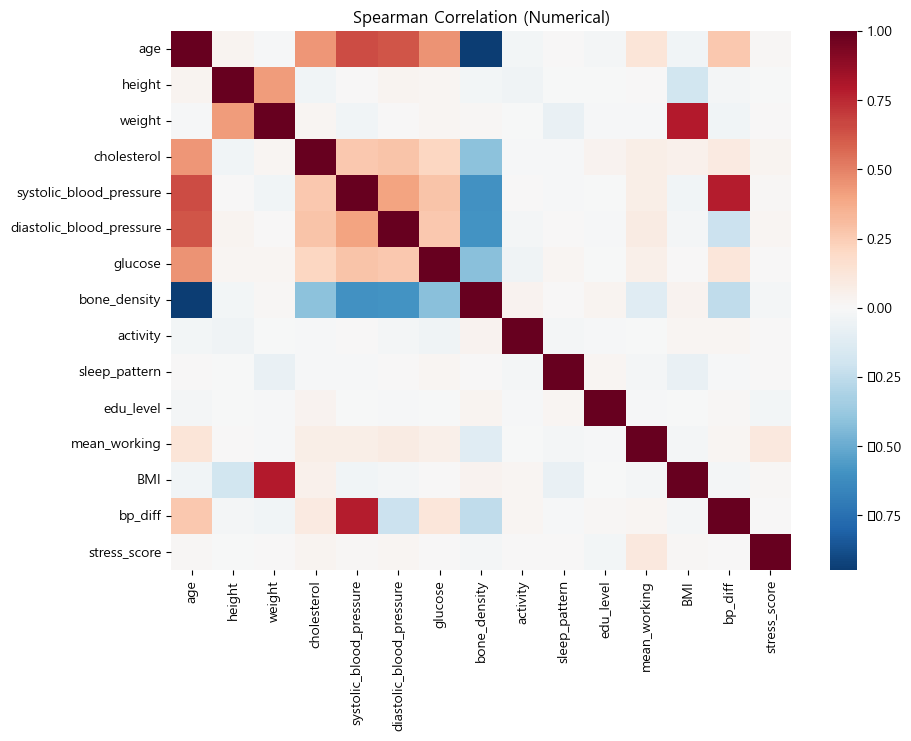

stress_score                1.000000
mean_working                0.109520
cholesterol                 0.026804
diastolic_blood_pressure    0.019255
age                         0.019001
systolic_blood_pressure     0.017789
BMI                         0.016798
activity                    0.009385
weight                      0.007825
bp_diff                     0.006089
sleep_pattern              -0.001377
glucose                    -0.003056
height                     -0.010767
bone_density               -0.022841
edu_level                  -0.027408
Name: stress_score, dtype: float64

In [14]:
train.head(5)

def missing_ratio(df):
    return (df.isna().mean()*100).round(2).rename("%missing")

info = pd.DataFrame({
    "dtype"     : train.dtypes,
    "%missing"  : missing_ratio(train),
    "n_unique"  : train.nunique()
})
display(info.sort_values("%missing", ascending=False))

# 수치형 기본 통계
display(train.describe().T)

# 범주형 빈도 상위 5개씩
cat_cols = train.select_dtypes("object").columns.drop(["ID"])
for col in cat_cols:
    print(f"\n▶ {col}")
    display(train[col].value_counts().head())

num_cols = train.select_dtypes(include=[np.number]).columns.drop("stress_score")

corr = train[num_cols.tolist() + ["stress_score"]].corr(method="spearman")
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=False, cmap="RdBu_r", center=0)
plt.title("Spearman Correlation (Numerical)")
plt.show()

corr["stress_score"].sort_values(ascending=False)

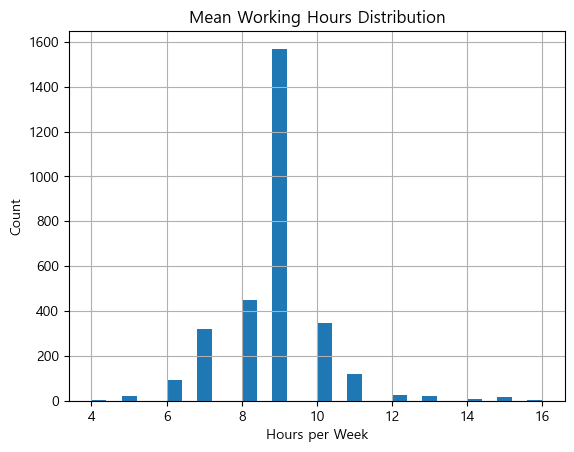

In [15]:
train['mean_working'].hist(bins=30)
plt.title('Mean Working Hours Distribution')
plt.xlabel('Hours per Week')
plt.ylabel('Count')
plt.show()

In [16]:
display(train['mean_working'].describe())
# working_group으로 피처 만들기

bins = [3, 8, 9, 16]  # 적절한 경계값 설정
labels = [0, 1, 2]     # 저, 중하, 중상, 고 근무

train['working_group'] = pd.cut(train['mean_working'], bins=bins, labels=labels, include_lowest=True)
test['working_group'] = pd.cut(test['mean_working'], bins=bins, labels=labels, include_lowest=True)

overwork_threshold = train['mean_working'].quantile(0.95)  # 상위 5% 기준값
train['is_overwork'] = (train['mean_working'] >= overwork_threshold).astype(int)
test['is_overwork'] = (test['mean_working'] >= overwork_threshold).astype(int)

display(train['working_group'].value_counts())
display(train['is_overwork'].value_counts())

count    3000.000000
mean        8.814333
std         1.326065
min         4.000000
25%         8.000000
50%         9.000000
75%         9.000000
max        16.000000
Name: mean_working, dtype: float64

working_group
1    1569
0     888
2     543
Name: count, dtype: int64

is_overwork
0    2803
1     197
Name: count, dtype: int64

count    3000.000000
mean      233.910523
std        24.333434
min       148.810000
25%       216.927500
50%       234.255000
75%       250.377500
max       313.350000
Name: cholesterol, dtype: float64

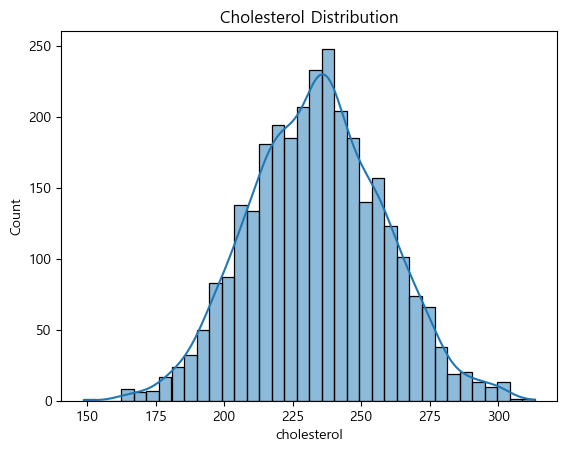

In [17]:
display(train['cholesterol'].describe())

sns.histplot(train['cholesterol'], kde=True)
plt.title('Cholesterol Distribution')
plt.show()

In [18]:
# # 콜레스테롤 관련 피처 만들기 -> 오히려 MAE 더 높게 나옴
# bins = [148.81, 199, 239, 313.35]
# labels = [0, 1, 2]

# train['cholesterol_level'] = pd.cut(train['cholesterol'], bins = bins, labels = labels)
# test['cholesterol_level'] = pd.cut(test['cholesterol'], bins = bins, labels = labels)

# display(train['cholesterol_level'].value_counts())

count    3000.000000
mean       25.533747
std         4.360648
min        12.092013
25%        22.365543
50%        25.332612
75%        28.361285
max        43.388951
Name: BMI, dtype: float64

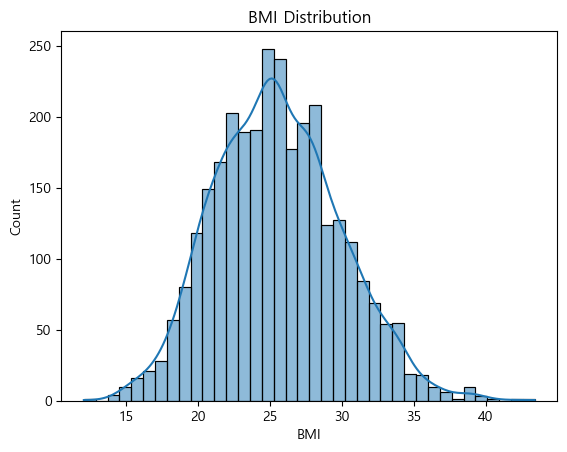

In [19]:
display(train['BMI'].describe())

sns.histplot(train['BMI'], kde=True)
plt.title('BMI Distribution')
plt.show()

In [20]:
train['work_sleep_imbalance'] = train['mean_working'] / (train['sleep_pattern'] + 1)
test['work_sleep_imbalance'] = test['mean_working'] / (test['sleep_pattern'] + 1)

display(train[['work_sleep_imbalance', 'stress_score']])

for col in train.columns:
    if(col == 'ID'):
        continue
    print(train[['stress_score', col]].corr())

,work_sleep_imbalance,stress_score
0,3.0,0.63
1,9.0,0.83
2,9.0,0.70
3,4.5,0.17
4,3.0,0.36
...,...,...
2995,4.5,0.02
2996,9.0,0.16
2997,9.0,0.16
2998,4.5,0.18


              stress_score       age
stress_score      1.000000  0.018656
age               0.018656  1.000000
              stress_score    height
stress_score      1.000000 -0.005664
height           -0.005664  1.000000
              stress_score    weight
stress_score      1.000000  0.011328
weight            0.011328  1.000000
              stress_score  cholesterol
stress_score      1.000000     0.021288
cholesterol       0.021288     1.000000
                         stress_score  systolic_blood_pressure
stress_score                 1.000000                 0.015635
systolic_blood_pressure      0.015635                 1.000000
                          stress_score  diastolic_blood_pressure
stress_score                  1.000000                  0.025351
diastolic_blood_pressure      0.025351                  1.000000
              stress_score   glucose
stress_score      1.000000 -0.006083
glucose          -0.006083  1.000000
              stress_score  bone_density
stress_scor

In [21]:
x_train = train.drop(['ID', 'stress_score'], axis = 1)
x_val = train['stress_score']
y_train = train['stress_score']

test = test.drop('ID', axis = 1)

In [22]:
lgbm = LGBMRegressor(random_state = 42)
lgbm.fit(x_train, y_train)

pred = lgbm.predict(test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 30
[LightGBM] [Info] Start training from score 0.482130


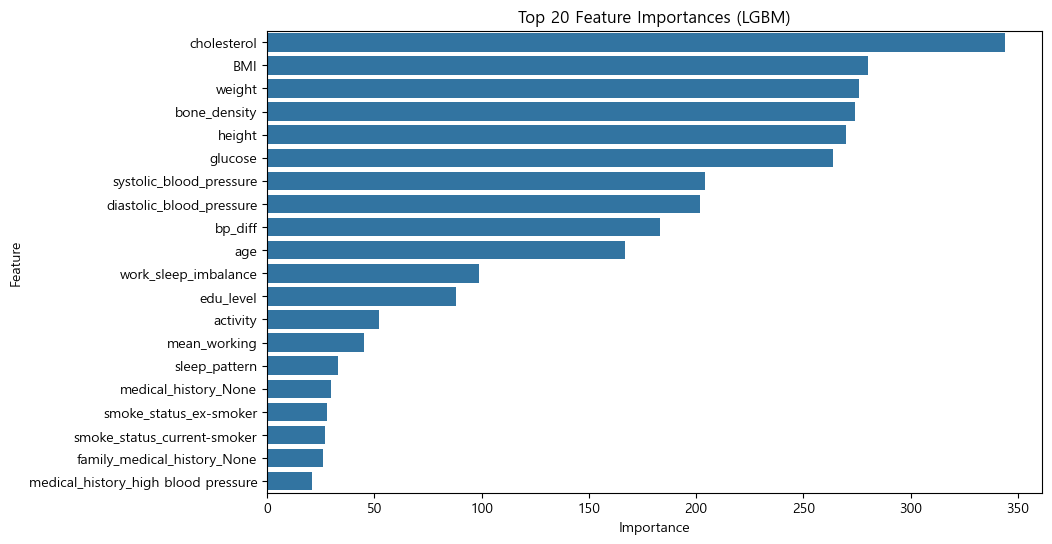

In [23]:
importances = lgbm.feature_importances_
feature_names = x_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (LGBM)')
plt.show()

In [24]:
submission = pd.read_csv('./sample_submission.csv')

In [25]:
submission['stress_score'] = pred
submission.head()

,ID,stress_score
0,TEST_0000,0.478682
1,TEST_0001,0.674498
2,TEST_0002,0.256676
3,TEST_0003,0.412132
4,TEST_0004,0.582463


In [26]:
submission.to_csv('submit.csv', index=False)

In [27]:
# train에서 나눠서 데이콘에서 측정하는 MAE와 다를수있음
# 성능이 올라갔는지 그대로인지 내려갔는지 경향만 파악할 수 있음
# 확인용으로만 쓸것

import datetime

# MAE 로그파일 세팅
def loging(MAE):
    with open('./mae_log', mode='a', encoding='utf-8') as f:
        current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        f.write(f"시간: {current_time} / MAE: {MAE}\n")

# MAE 체크용
train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)

X_train = train_set.drop(['ID', 'stress_score'], axis=1)
y_train = train_set['stress_score']

X_val = val_set.drop(['ID', 'stress_score'], axis=1) 
y_val = val_set['stress_score']

lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

val_pred = lgbm.predict(X_val)

MAE = mean_absolute_error(y_val, val_pred)

print(f"모델의 검증 MAE 점수: {MAE}")
loging(MAE)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481912
모델의 검증 MAE 점수: 0.19995829591524802
